<a href="https://colab.research.google.com/github/SantiagoPeinadoPolo/Estad/blob/main/Entrega_opcional_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# INSTALACIÓN LIBRERIAS
!pip install PyPortfolioOpt
!pip install missingno
!pip install quantstats

# LIBRERIAS A EMPLEAR
import missingno as mso
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pypfopt import EfficientFrontier, plotting
import cvxpy as cp
import quantstats as qs
import plotly.express as px
import plotly.graph_objects as go


<class 'pandas.core.frame.DataFrame'>
Index: 938 entries, 30.09.2025 to 30.06.2021
Data columns (total 7 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   Robeco QI Global Conservative Equities D EUR                                  938 non-null    float64
 1   Fidelity S&P 500 Index Fund EUR P Acc (Hedged)                                938 non-null    float64
 2   Robeco BP Global Premium Equities DH EUR                                      938 non-null    float64
 3   Robeco Active Quant EM Equities D Accumulation EUR                            938 non-null    float64
 4   Flossbach Storch Bnd Opportu Rt Acc Eur                                       938 non-null    float64
 5   Gamma Global A FI                                                             938 non-null    float64
 6   Schroder International S

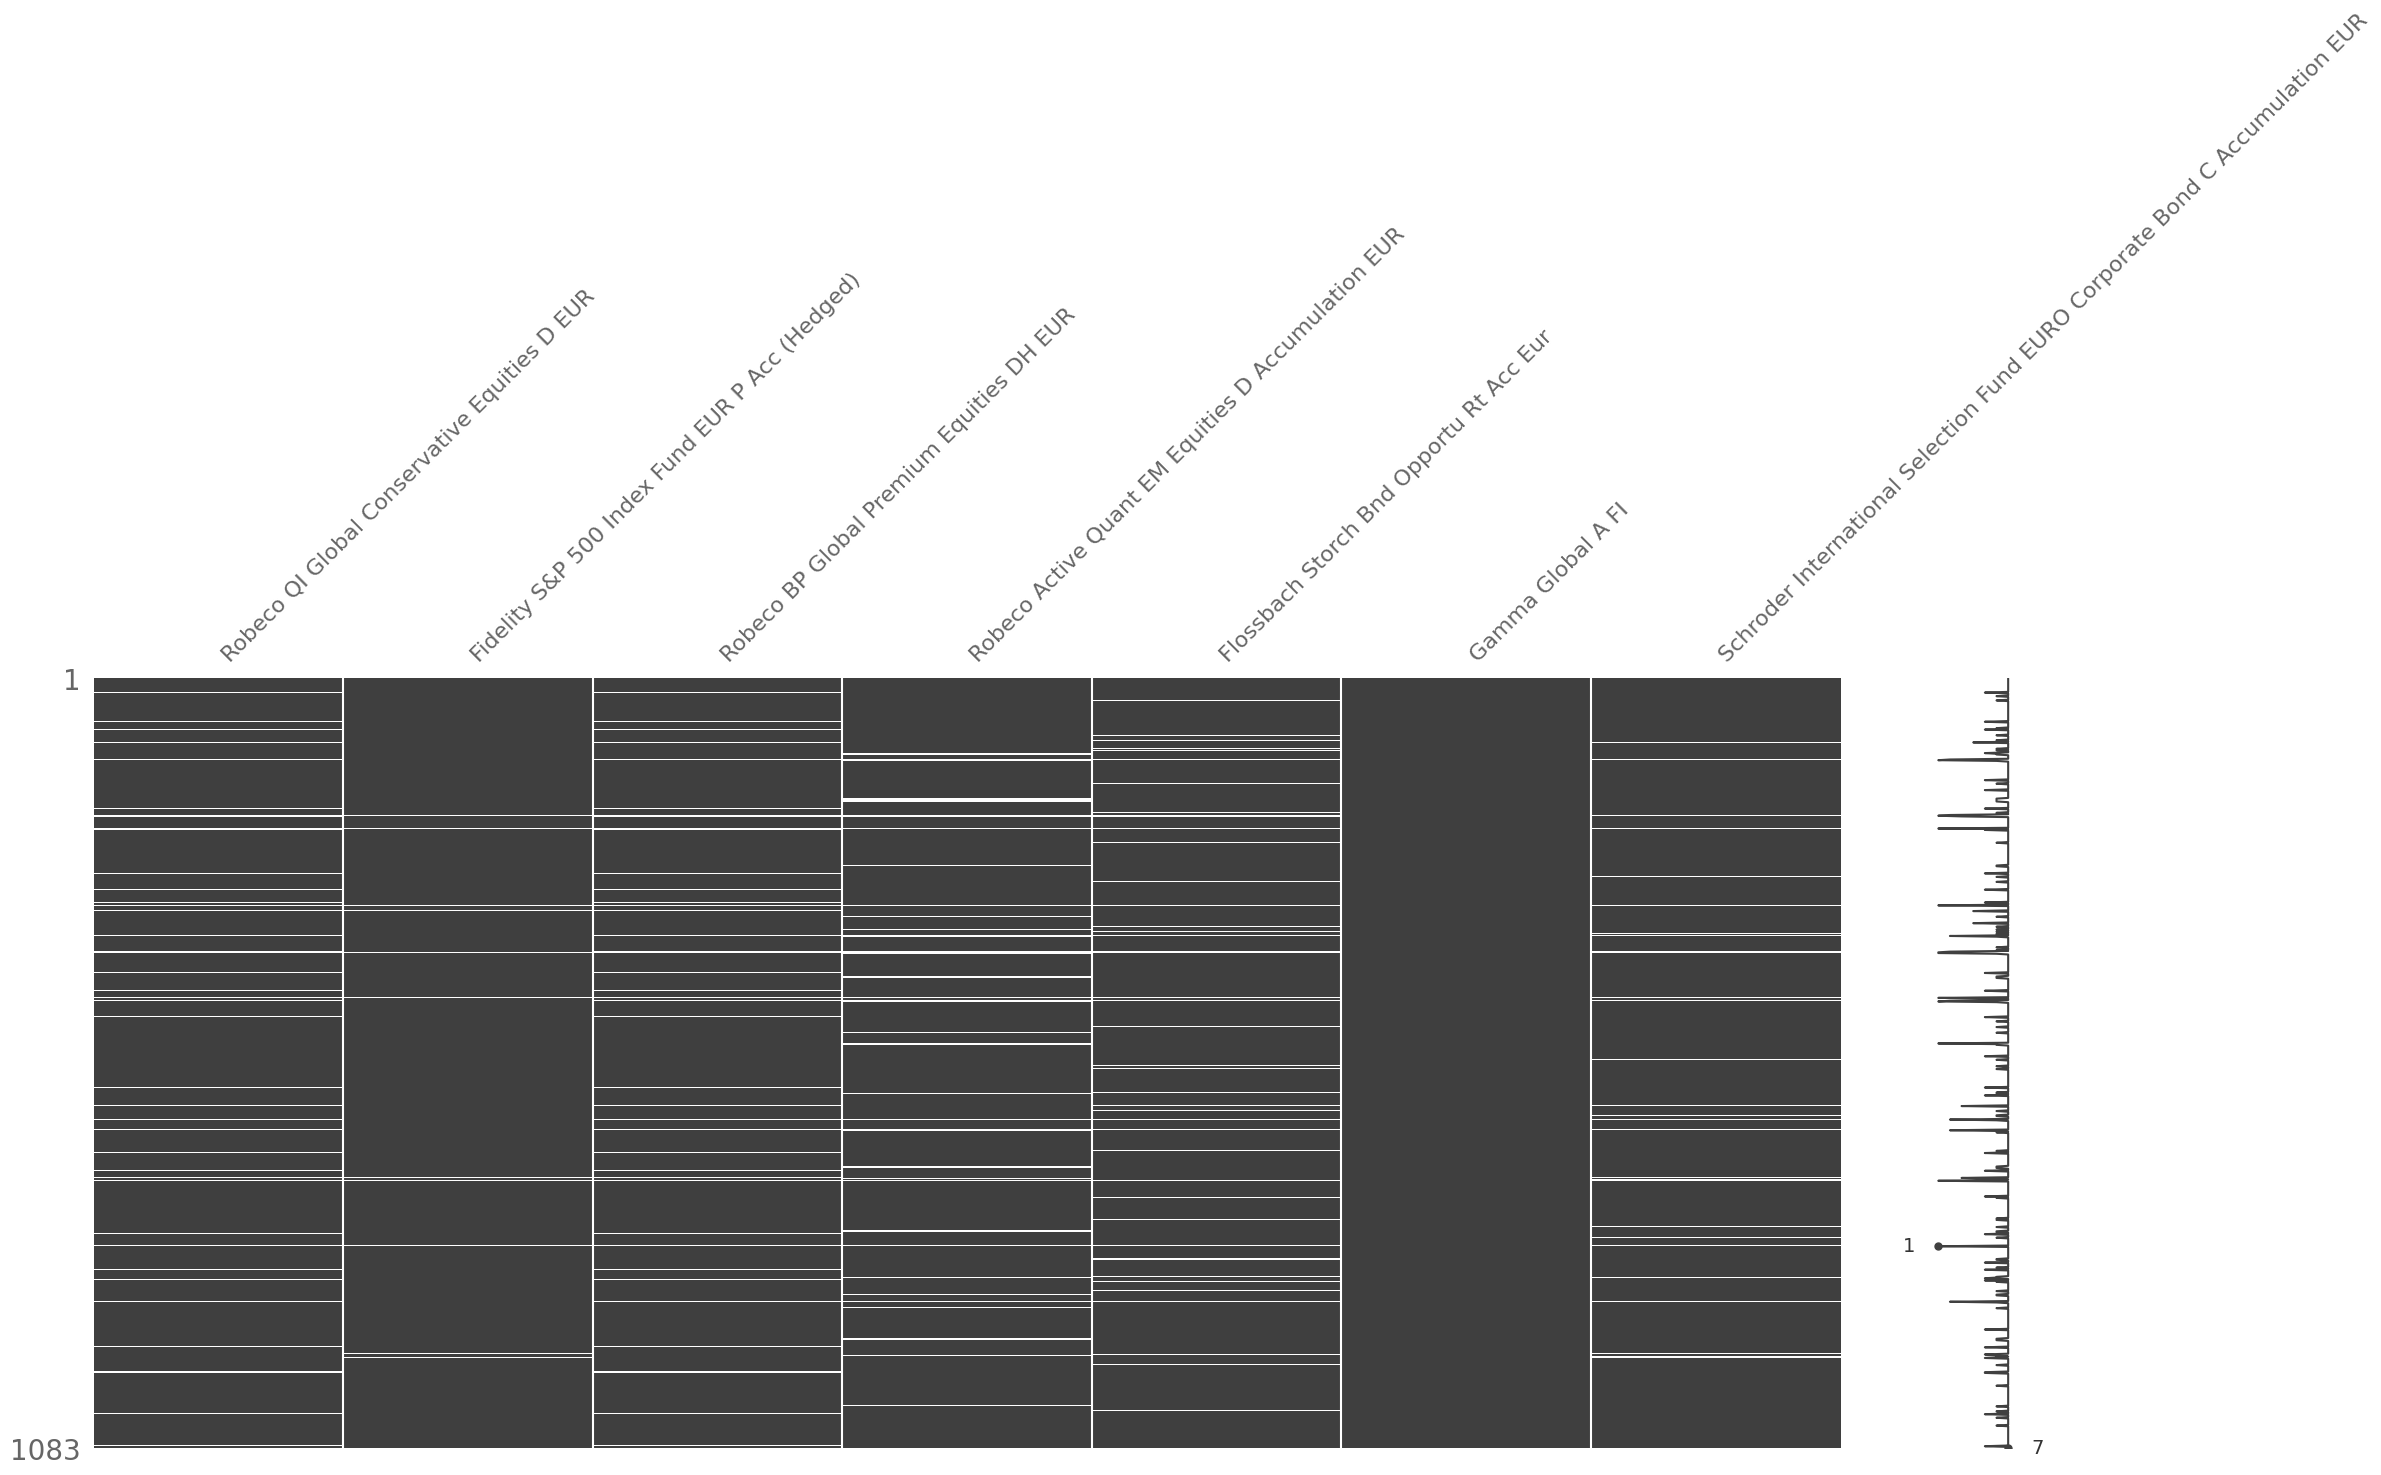

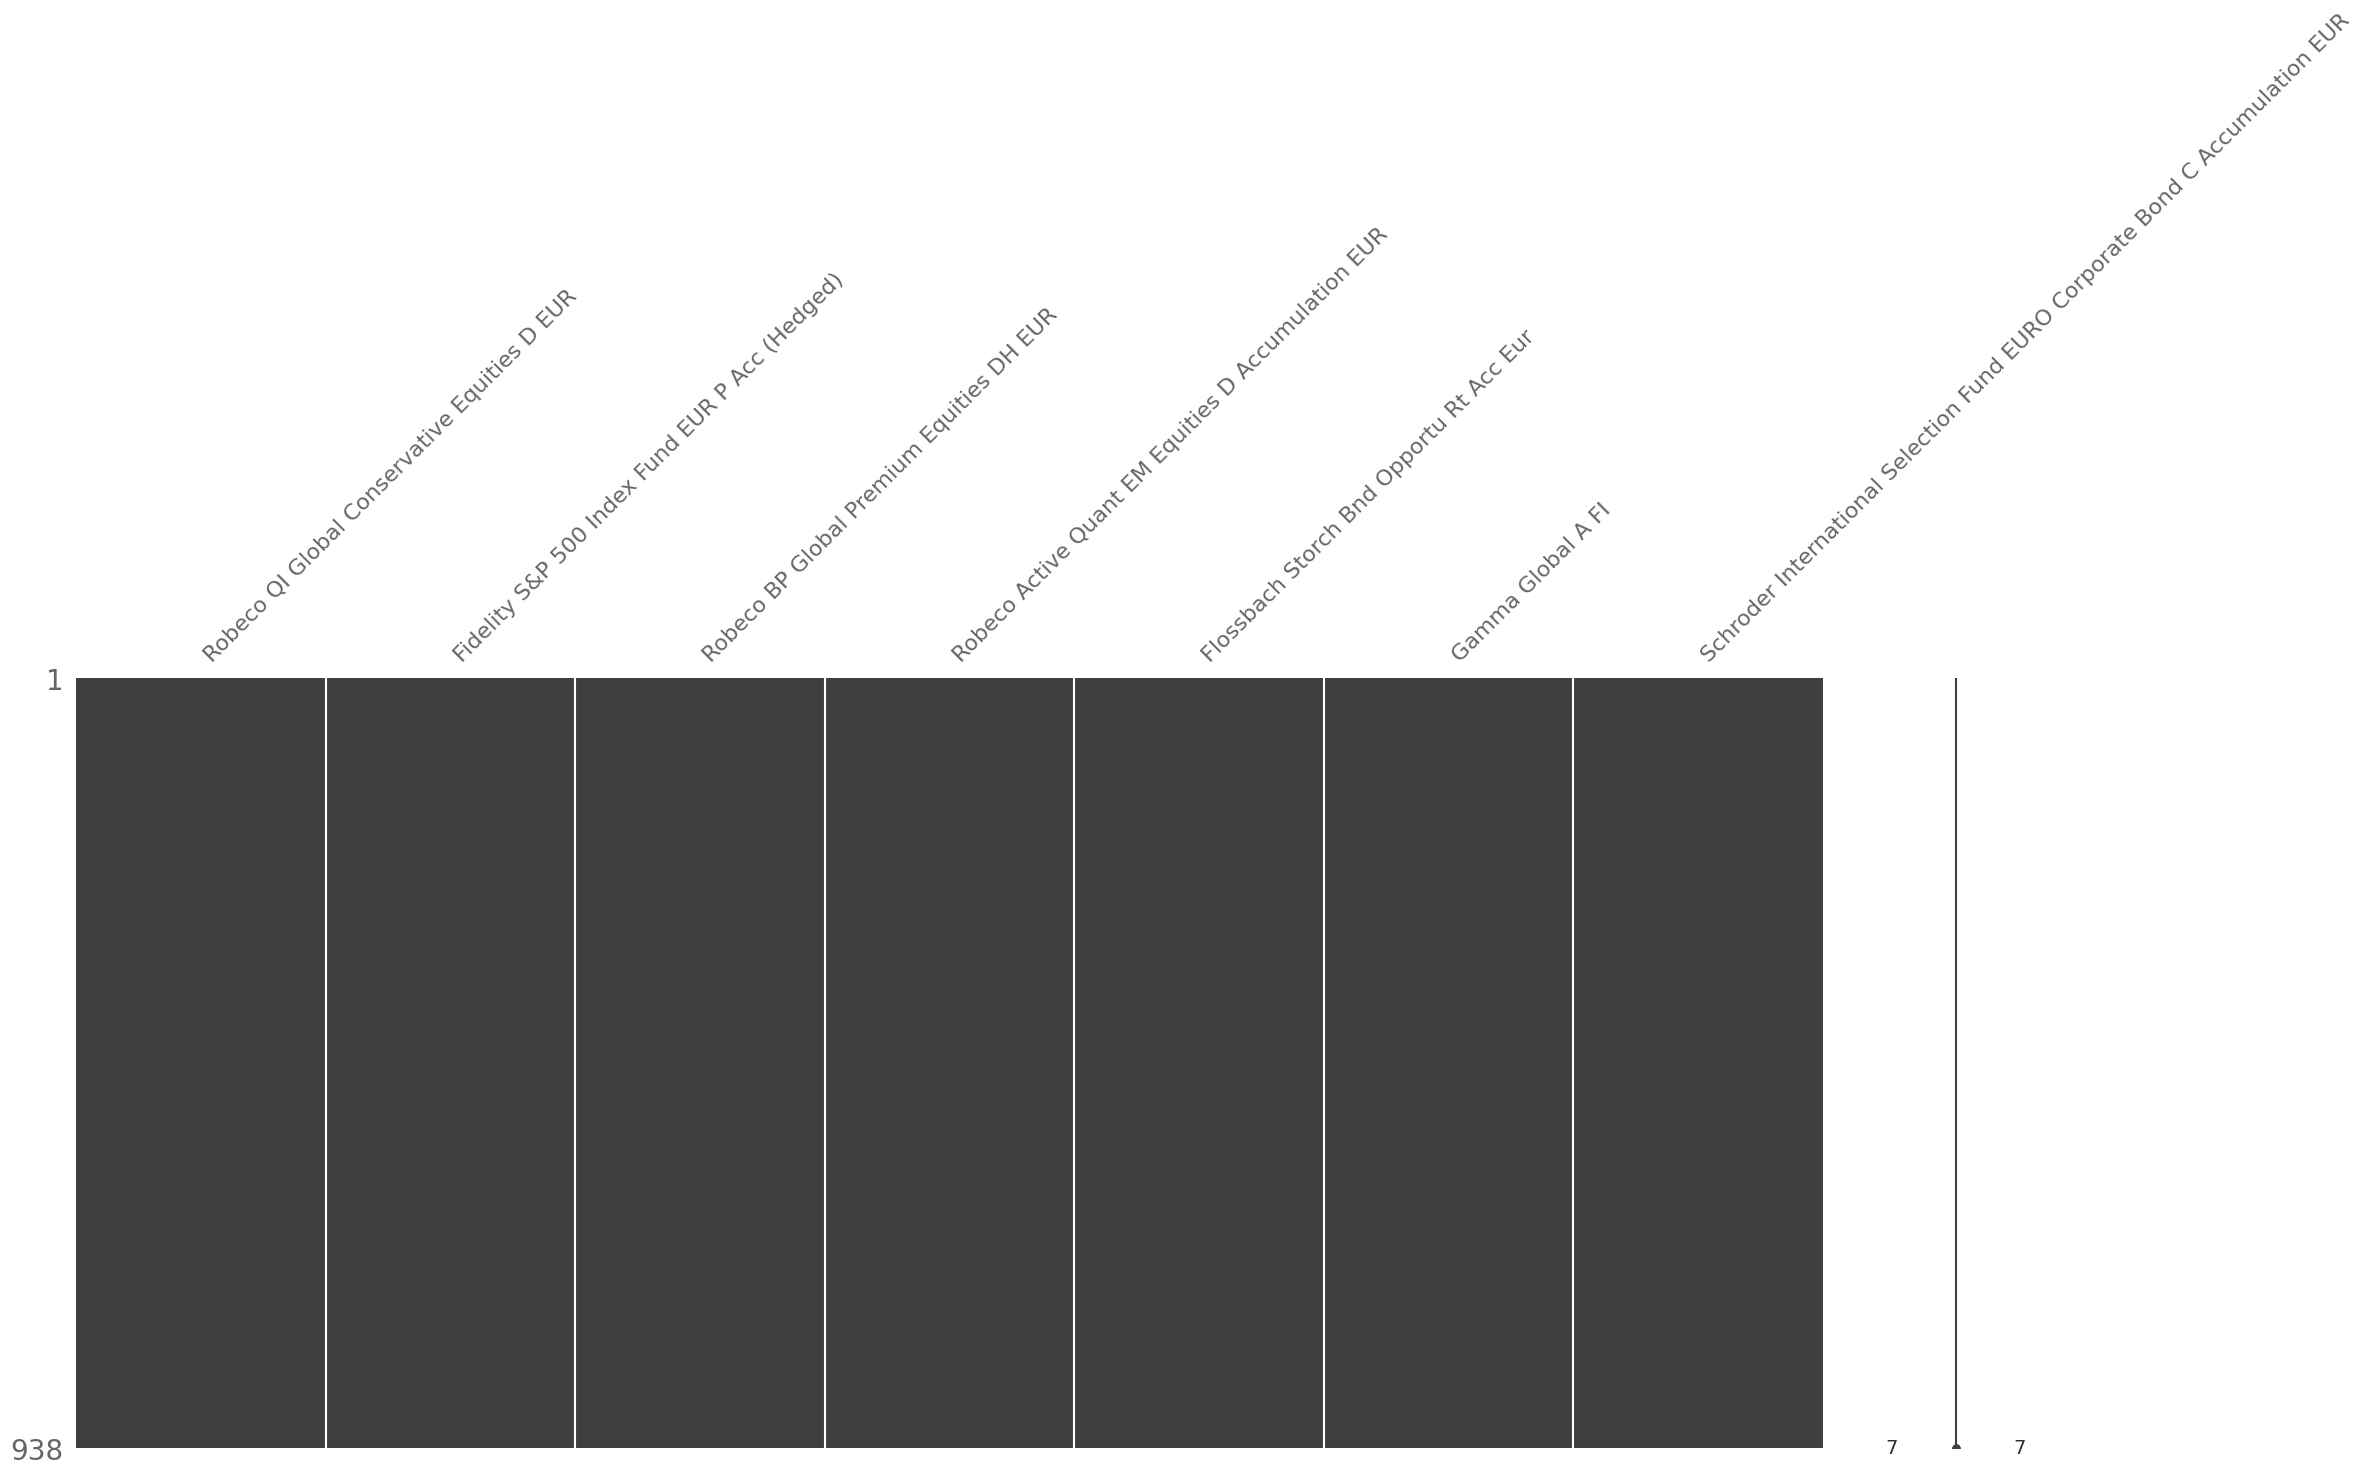

In [ ]:
# EXTRACCIÓN DE INFORMACIÓN DE EXCEL A FORMATO PANDAS Y TRATAMIENTO DE LOS DATOS

ruta = "/content/Prices.xlsx"
df = pd.read_excel(ruta, index_col=0)
mso.matrix(df)                          # Con la función de missigno evaluamos los datos Pre
Precios = df.dropna(how="any", axis=0)  # Eliminamos las filas en las que encontremos datos #NaN
mso.matrix(Precios)                     # Con la función de missigno evaluamos los datos Post
Precios.info()


In [ ]:
# INVERTIMOS EL ORDEN DE LOS DATOS DEL DATA FRAME, DE OTRA FORMA, LAS RENTABILIDADES NOS SALDRÁN NEGATIVAS
Precios = Precios.iloc[::-1]
display(Precios.head(15))

Robeco QI Global Conservative Equities D EUR  \
Fecha                                                      
30.06.2021                                        239.74   
01.07.2021                                        239.78   
02.07.2021                                        241.98   
06.07.2021                                        241.46   
07.07.2021                                        243.05   
08.07.2021                                        240.25   
09.07.2021                                        242.80   
12.07.2021                                        243.56   
13.07.2021                                        243.73   
14.07.2021                                        244.57   
15.07.2021                                        243.90   
16.07.2021                                        243.51   
19.07.2021                                        240.76   
20.07.2021                                        243.16   
21.07.2021                                        244.05   

            Fidelity S&P 500 Index Fund EUR P Acc (Hedged)  \
Fecha                                                        
30.06.2021                                           7.601   
01.07.2021                                           7.641   
02.07.2021                                           7.699   
06.07.2021                                           7.683   
07.07.2021                                           7.709   
08.07.2021                                           7.643   
09.07.2021                                           7.730   
12.07.2021                                           7.756   
13.07.2021                                           7.729   
14.07.2021                                           7.738   
15.07.2021                                           7.712   
16.07.2021                                           7.654   
19.07.2021                                           7.532   
20.07.2021                                           7.646   
21.07.2021                                           7.709   

            Robeco BP Global Premium Equities DH EUR  \
Fecha                                                  
30.06.2021                                    131.62   
01.07.2021                                    132.67   
02.07.2021                                    132.80   
06.07.2021                                    131.16   
07.07.2021                                    131.23   
08.07.2021                                    129.05   
09.07.2021                                    131.72   
12.07.2021                                    132.56   
13.07.2021                                    131.94   
14.07.2021                                    131.33   
15.07.2021                                    130.25   
16.07.2021                                    128.79   
19.07.2021                                    125.56   
20.07.2021                                    127.05   
21.07.2021                                    129.11   

            Robeco Active Quant EM Equities D Accumulation EUR  \
Fecha                                                            
30.06.2021                                             226.50    
01.07.2021                                             224.40    
02.07.2021                                             224.45    
06.07.2021                                             223.13    
07.07.2021                                             222.09    
08.07.2021                                             218.56    
09.07.2021                                             220.59    
12.07.2021                                             222.30    
13.07.2021                                             222.37    
14.07.2021                                             223.60    
15.07.2021                                             224.26    
16.07.2021                                             222.05    
19.07.2021                                             218.

In [ ]:
# CALCULAMOS LA RENTABILIDAD DE LOS ACTIVOS

RENTABILIDAD = np.log(Precios).diff().dropna()
RENTABILIDAD.shape                              #Encontramos 937 resultados porque la primera fila el rendimiento sera Nan al no haber dia de comparación anterior. Lo hemos eliminado con el dropna anterior.

(937, 7)

In [ ]:
# GENERACIÓN DE CARTERAS ALEATORIAS (SIMULAMOS PESOS ALEATORIOS DE LOS ACTIVOS DENTRO DE LA CARTERA)

# Generamos pesos aleatorios.
nº_carteras = 50000
nº_activos = Precios.shape[1]

rng = np.random.default_rng(seed=42)                        # Generamos números aleatorios fijando una semilla para poder hacer el modelo replicable.
pesos = np.abs(rng.normal(size=(nº_carteras, nº_activos)))  # Generamos pesos aleatorios asumiento una distribución normal (aunque no es asi, en numerosos supuestos financieros se asume normalidad en las distribuciones)
pesos = pesos / np.sum(pesos, axis=1, keepdims=True)        # Normalizamos los pesos ya que su suma esta limitada a 1 (no habrá apalancamiento)

pesos.shape                                                 # Encontraremos 50K carteras con 7 activos dentro.

(50000, 7)

In [ ]:
# CALCULAMOS LA RENTABILIDAD DE LAS 50K CARTERAS

Rent_carteras = RENTABILIDAD @ pesos.T  # Con multiplicación matricial calculamos la rentabilidad (937, 7) @ (7 50000) -> (937, 50000)
Rent_carteras.shape

(937, 50000)

In [ ]:
# CALCULAMOS RENTABILIDAD Y RIESGO DE LAS CARTERAS

# Rentabilidad esperada como rentabilidad media
Rent_esperada = Rent_carteras.mean(axis=0)  # Axis=0 para calcularla por columnas (nuestras carteras)
# Riesgo de cada cartera como desviacióne estandar o volatilidad
volatilidad = Rent_carteras.std(axis=0)     # Axis=0 para calcularla por columnas (nuestras carteras)

display(Rent_esperada.head(5))
display(volatilidad.head(5))

0    0.000244
1    0.000224
2    0.000270
3    0.000306
4    0.000308
dtype: float64

0    0.004517
1    0.004146
2    0.006003
3    0.006148
4    0.005531
dtype: float64

In [ ]:
# GRAFICA DE CARTERAS Y CARTERA MIN VOL, MAX SHARPE

RF_ANUAL_EFECTIVA = 0.03   # p.ej. 0.03 para 3%. Si la tienes en efectivo anual, la convierto a log más abajo.
TRADING_DAYS = 252

# Asegurar que carteras son arrays 1D (por si llegan como DataFrame/Serie)
mu_p_daily  = pd.Series(Rent_esperada).astype(float).values.ravel()
sig_p_daily = pd.Series(volatilidad).astype(float).values.ravel()

# Activos: medias y std DIARIOS (log-returns)
asset_mu_daily  = RENTABILIDAD.mean(axis=0).astype(float)
asset_sig_daily = RENTABILIDAD.std(axis=0).astype(float)

# -------- Anualización (LOG RETURNS) ----------
mu_p_annual      = TRADING_DAYS * mu_p_daily
asset_mu_annual  = TRADING_DAYS * asset_mu_daily

sig_p_annual     = sig_p_daily  * np.sqrt(TRADING_DAYS)
asset_sig_annual = asset_sig_daily * np.sqrt(TRADING_DAYS)

# -------- Sharpe (con log-returns) ----------
# Si RF_ANUAL_EFECTIVA es efectiva anual (1+rf), la paso a log anual:
rf_log_annual = np.log1p(RF_ANUAL_EFECTIVA)  # ~ RF continuo anual
den = np.where(sig_p_annual==0, np.nan, sig_p_annual)
sharpe = (mu_p_annual - rf_log_annual) / den

# Mejor Sharpe y mínima volatilidad
idx_max_sharpe = int(np.nanargmax(sharpe))
idx_min_vol    = int(np.nanargmin(sig_p_annual))

# -------- DataFrames auxiliares ----------
df_port = pd.DataFrame({
    "Riesgo": sig_p_annual,
    "Rentabilidad": mu_p_annual,
    "Sharpe": sharpe
})

df_assets = pd.DataFrame({
    "Riesgo": asset_sig_annual.values,
    "Rentabilidad": asset_mu_annual.values,
    "Activo": asset_mu_annual.index
})

# -------- Plotly: nube de carteras + overlay de activos ----------
fig = px.scatter(
    df_port,
    x="Riesgo", y="Rentabilidad",
    color="Sharpe", color_continuous_scale="Viridis",
    hover_data={
        "Riesgo":":.2%",
        "Rentabilidad":":.2%",
        "Sharpe":":.2f"
    },
    title="Carteras aleatorias: Rentabilidad vs. Riesgo (anual, log-returns)"
)

# Puntos especiales: Máx Sharpe y Mín Vol
fig.add_trace(go.Scatter(
    x=[sig_p_annual[idx_max_sharpe]], y=[mu_p_annual[idx_max_sharpe]],
    mode="markers",
    marker=dict(size=14, symbol="circle-open", line=dict(width=2)),
    name="Máx. Sharpe"
))
fig.add_trace(go.Scatter(
    x=[sig_p_annual[idx_min_vol]], y=[mu_p_annual[idx_min_vol]],
    mode="markers",
    marker=dict(size=12, symbol="circle", line=dict(width=1)),
    name="Mín. Vol"
))

# Overlay de activos (con etiquetas)
fig.add_trace(go.Scatter(
    x=df_assets["Riesgo"], y=df_assets["Rentabilidad"],
    mode="markers+text",
    text=df_assets["Activo"],
    textposition="top center",
    marker=dict(size=10, color="black"),
    name="Activos"
))

fig.update_layout(
    width=1800,
    height=900,
    xaxis_title="Riesgo (σ anual)",
    yaxis_title="Rentabilidad esperada (anual, log)",
    legend_title="Leyenda",
    hovermode="closest"
)

# Ejes en formato porcentaje si te gusta más (descomenta):
fig.update_xaxes(tickformat=".1%")
fig.update_yaxes(tickformat=".1%")

fig.show()

In [ ]:
# PESOS DE CARTERAS Y CARTERA MAX RENDIMIENTO PARA VOL DETERMINADA

# ---- Alineo nombres de activos a los pesos ----
# pesos: (n_carteras, n_activos) -> DataFrame con columnas = activos
pesos_df = pd.DataFrame(pesos, columns=RENTABILIDAD.columns)

# ---- Anualización (LOG RETURNS) ----
mu_p_annual  = TRADING_DAYS * pd.Series(Rent_esperada).astype(float).values.ravel()
sig_p_annual = np.sqrt(TRADING_DAYS) * pd.Series(volatilidad).astype(float).values.ravel()

# ---- Sharpe (log) ----
rf_log_annual = np.log1p(RF_ANUAL_EFECTIVA)  # convierte tasa efectiva anual a log anual
den = np.where(sig_p_annual == 0, np.nan, sig_p_annual)
sharpe = (mu_p_annual - rf_log_annual) / den

idx_max_sharpe = int(np.nanargmax(sharpe))
idx_min_vol    = int(np.nanargmin(sig_p_annual))

# -------- 1) y 2) Composición en % de Máx. Sharpe y Mín. Vol --------
tabla_max_sharpe = (100 * pesos_df.iloc[idx_max_sharpe]).to_frame(name="Max.Sharpe (%)").round(2)
tabla_min_vol    = (100 * pesos_df.iloc[idx_min_vol]).to_frame(name="Min.Vol (%)").round(2)

print("Composición cartera Máx. Sharpe:")
display(tabla_max_sharpe.sort_values("Max.Sharpe (%)", ascending=False))
print(f"μ={mu_p_annual[idx_max_sharpe]:.2%}  |  σ={sig_p_annual[idx_max_sharpe]:.2%}  |  Sharpe={sharpe[idx_max_sharpe]:.2f}\n")

print("Composición cartera Mín. Vol:")
display(tabla_min_vol.sort_values("Min.Vol (%)", ascending=False))
print(f"μ={mu_p_annual[idx_min_vol]:.2%}  |  σ={sig_p_annual[idx_min_vol]:.2%}  |  Sharpe={sharpe[idx_min_vol]:.2f}\n")

# -------- 3) Cartera de MÁX. RENTABILIDAD dentro de una banda de riesgo objetivo --------
def idx_max_rtd_para_riesgo(vol_objetivo_anual, tolerancia_abs=0.005):
    """
    Busca la cartera con mayor μ anual entre las que caen en la banda:
    [vol_objetivo_anual - tolerancia_abs, vol_objetivo_anual + tolerancia_abs].
    Si no hay carteras en banda, usa la más cercana en riesgo.
    vol_objetivo_anual en términos absolutos (ej: 0.12 = 12%)
    tolerancia_abs en términos absolutos de σ (ej: 0.005 ≈ ±0.5 pp de σ)
    """
    dif = np.abs(sig_p_annual - vol_objetivo_anual)
    mask = dif <= tolerancia_abs
    if not np.any(mask):
        candidatos = [int(np.argmin(dif))]
    else:
        candidatos = np.where(mask)[0].tolist()
    return candidatos[int(np.argmax(mu_p_annual[candidatos]))]

# === Ejemplo: objetivo σ=x% con banda ±0.5 pp ===
vol_obj = 0.10
tol = 0.005
idx_best_rtd = idx_max_rtd_para_riesgo(vol_obj, tolerancia_abs=tol)

tabla_best_rtd = (100 * pesos_df.iloc[idx_best_rtd]).to_frame(
    name=f"Max.Rtd @ σ≈{vol_obj:.1%} (±{tol:.1%}) (%)"
).round(2)

print(f"Cartera MÁX. RENTABILIDAD para riesgo objetivo ≈ {vol_obj:.1%} (±{tol:.1%}):")
print(f"μ={mu_p_annual[idx_best_rtd]:.2%}  |  σ={sig_p_annual[idx_best_rtd]:.2%}")
display(tabla_best_rtd.sort_values(tabla_best_rtd.columns[0], ascending=False))


Composición cartera Máx. Sharpe:


Max.Sharpe (%)
Gamma Global A FI                                            71.50
Robeco QI Global Conservative Equities D EUR                  9.54
Schroder International Selection Fund EURO Corp...            7.74
Robeco Active Quant EM Equities D Accumulation EUR            3.94
Flossbach Storch Bnd Opportu Rt Acc Eur                       3.26
Robeco BP Global Premium Equities DH EUR                      2.95
Fidelity S&P 500 Index Fund EUR P Acc (Hedged)                1.08

μ=7.14%  |  σ=4.53%  |  Sharpe=0.92

Composición cartera Mín. Vol:


Min.Vol (%)
Schroder International Selection Fund EURO Corp...        90.25
Robeco Active Quant EM Equities D Accumulation EUR         5.53
Gamma Global A FI                                          1.75
Robeco QI Global Conservative Equities D EUR               0.87
Fidelity S&P 500 Index Fund EUR P Acc (Hedged)             0.68
Robeco BP Global Premium Equities DH EUR                   0.66
Flossbach Storch Bnd Opportu Rt Acc Eur                    0.26

μ=3.47%  |  σ=2.08%  |  Sharpe=0.25

Cartera MÁX. RENTABILIDAD para riesgo objetivo ≈ 10.0% (±0.5%):
μ=9.17%  |  σ=10.18%


Max.Rtd @ σ≈10.0% (±0.5%) (%)
Robeco BP Global Premium Equities DH EUR                                    35.88
Robeco QI Global Conservative Equities D EUR                                34.67
Gamma Global A FI                                                           18.23
Fidelity S&P 500 Index Fund EUR P Acc (Hedged)                               9.00
Robeco Active Quant EM Equities D Accumulation EUR                           1.32
Schroder International Selection Fund EURO Corp...                           0.89
Flossbach Storch Bnd Opportu Rt Acc Eur                                      0.01

from matplotlib import pyplot as plt
_df_0['Max.Rtd @ σ≈10.0% (±0.5%) (%)'].plot(kind='hist', bins=20, title='Max.Rtd @ σ≈10.0% (±0.5%) (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Max.Rtd @ σ≈10.0% (±0.5%) (%)'].plot(kind='line', figsize=(8, 4), title='Max.Rtd @ σ≈10.0% (±0.5%) (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# GENERACIÓN DE REPORT COMPLETO DE LA CARTERA "VOLATILIDAD OBJETIVO" VS ÍNDICE DE REFERENCIA "MSCI ACWI" EN FORMATO HTLM

# "El MSCI ACWI recoge la representación de las empresas de gran y mediana capitalización de los mercados desarrollados (DM) y emergentes (EM).
#  El índice abarca aproximadamente el 85 % del conjunto de oportunidades de inversión en renta variable a nivel mundial."

######################################################################################################################################################

# --- 0) Normalizar índice de fechas de RENTABILIDAD a DatetimeIndex ---
# Intenta "mixed" (pandas >=2.0). Si falla, usa formato europeo explícito "%d.%m.%Y".
try:
    idx = pd.to_datetime(RENTABILIDAD.index, format='mixed', dayfirst=True, errors='raise')
except Exception:
    idx = pd.to_datetime(RENTABILIDAD.index, format='%d.%m.%Y', dayfirst=True, errors='coerce')

# Elimina filas con fecha inválida y asigna el índice limpio
valid = ~idx.isna()
if not np.all(valid):
    RENTABILIDAD = RENTABILIDAD.loc[valid].copy()
    idx = idx[valid]
RENTABILIDAD.index = idx
# Orden cronológico ascendente (requerido por QuantStats)
RENTABILIDAD = RENTABILIDAD.sort_index()

# --- 1) Retornos de la cartera objetivo ---
w = pesos_df.iloc[int(idx_best_rtd)].astype(float).to_numpy()
# Asegurar el mismo orden de columnas
rets_log = RENTABILIDAD.loc[:, pesos_df.columns]
# Serie de retornos log de la cartera
rp_log = pd.Series(rets_log.to_numpy() @ w, index=rets_log.index, name='rp_log')

# --- 2) Convertir a retornos simples para QuantStats ---
rp = np.expm1(rp_log)
rp.name = 'rp'
# Limpieza de infinitos y NaN
rp = rp.replace([np.inf, -np.inf], np.nan).dropna()
# Seguridad: ordenar índice ascendente
rp = rp.sort_index()

# --- 3) Equity (base 100) ---
equity = 100 * (1 + rp).cumprod()
equity.name = 'equity_100'


# --- 4) Reporte completo QuantStats en HTML (Empleado como índice de referencia el MSCI ACWI) ---
rf = float(RF_ANUAL_EFECTIVA)
qs.reports.html(rp, benchmark='ACWI', rf=rf, output='CarteraObjetivo.html')

HVaR (hist) 95% cartera: 0.9489%
CHVaR (hist) 95% cartera: 1.5151%
VaR param (normal) 95%: 1.0179%


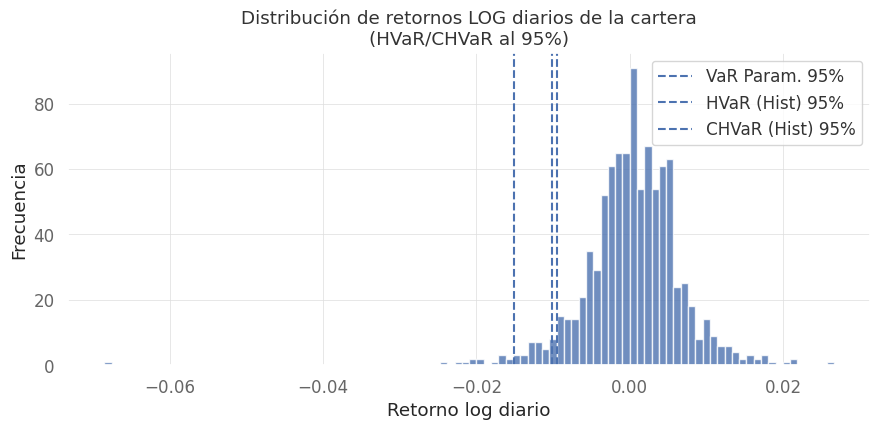


CHVaR de la cartera objetivo: 1.5151%


In [ ]:
# CÁLCULO DEL CHVaR COMO MÉTRICA DE RIESGO DE LA CARTERA (CHVaR DIARIO 95% CONFIANZA)

# --- Funciones de riesgo (idénticas a tu script) ---
def var_historico(r, level=1):
    """HVaR (VaR histórico) al (100-level)% de confianza."""
    return -np.percentile(r, level)


def cvar_historico(r, level=1):
    """CHVaR/CVaR histórico (Expected Shortfall)."""
    corte = np.percentile(r, level)
    r_arr = np.asarray(r)
    return -r_arr[r_arr <= corte].mean()


def var_parametrico_normal(r, level=1):
    """
    VaR paramétrico asumiendo Normal(m, s).
    level es la cola (p.ej. 1 para 99%).
    Usa SciPy si está disponible; si no, usa un z aproximado.
    """
    arr = np.asarray(r, dtype=float)
    m = float(np.mean(arr))
    s = float(np.std(arr, ddof=1))
    alpha = level / 100.0
    try:
        from scipy.stats import norm
        z = norm.ppf(alpha) # negativo para alpha pequeño
    except Exception:
        z_table = {10: -1.28155, 5: -1.64485, 2.5: -1.95996, 1: -2.32635}
        closest = min(z_table.keys(), key=lambda k: abs(k - level))
        z = z_table[closest]
    return -(m + s * z)


# --- Función principal ---
def calc_chvar_log_idx_best_rtd(confianza=95):
    """Calcula HVaR, CHVaR y VaR paramétrico sobre RETORNOS LOG de la cartera idx_best_rtd.
    Imprime resultados y grafica histograma con líneas de VaR/CHVaR. Devuelve CHVaR."""
    # Cola (1 para 99%)
    level = 100 - int(confianza)


    # Retornos LOG de la cartera seleccionada
    w = pesos_df.iloc[int(idx_best_rtd)].astype(float).to_numpy()
    rets_log = RENTABILIDAD.loc[:, pesos_df.columns]
    rp_log = pd.Series(rets_log.to_numpy() @ w, index=rets_log.index, name='rp_log')
    rp_log = rp_log.sort_index()


    # Cálculo de métricas sobre log-returns
    var_port_hist = var_historico(rp_log, level=level)
    cvar_port_hist = cvar_historico(rp_log, level=level)
    var_port_param = var_parametrico_normal(rp_log, level=level)


    # Salida por pantalla (idéntico estilo)
    print(f"HVaR (hist) {confianza}% cartera: {var_port_hist:.4%}")
    print(f"CHVaR (hist) {confianza}% cartera: {cvar_port_hist:.4%}")
    print(f"VaR param (normal) {confianza}%: {var_port_param:.4%}")


    # Gráfico (eje x: log-returns)
    plt.figure(figsize=(9, 4.5))
    plt.hist(rp_log, bins=100, alpha=0.8)
    plt.title(f"Distribución de retornos LOG diarios de la cartera\n(HVaR/CHVaR al {confianza}%)")
    plt.xlabel("Retorno log diario")
    plt.ylabel("Frecuencia")
    plt.axvline(-var_port_param, linestyle="--", label=f"VaR Param. {confianza}%")
    plt.axvline(-var_port_hist, linestyle="--", label=f"HVaR (Hist) {confianza}%")
    plt.axvline(-cvar_port_hist, linestyle="--", label=f"CHVaR (Hist) {confianza}%")
    plt.legend()
    plt.tight_layout()
    plt.show()


    return cvar_port_hist

    # Calcular y mostrar el CHVaR de la cartera objetivo
chvar_objetivo = calc_chvar_log_idx_best_rtd()
print(f"\nCHVaR de la cartera objetivo: {chvar_objetivo:.4%}")